In [60]:
import sys
import random
import numpy as np
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
import ipyvolume as ipv

from IPython.display import Image
from scipy import optimize



from tyssue import config, Sheet, SheetGeometry, History, EventManager
from tyssue import SheetGeometry as geom
from tyssue import PlanarGeometry as geom
from tyssue.draw.plt_draw import create_gif
from tyssue.draw.plt_draw import plot_forces
from tyssue.draw import sheet_view
from tyssue.dynamics import effectors, model_factory
from tyssue.dynamics import PlanarModel
from tyssue.dynamics import SheetModel as model
from tyssue.generation import three_faces_sheet
from tyssue.solvers.viscous import EulerSolver
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.io import hdf5
import copy

from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model


from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division

import warnings
warnings.filterwarnings('ignore')

In [61]:
def length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity):
    for edge in range(len(cellmap.edge_df)):
        
        FRCnewValue = random.randrange(FRC_lower_length_elasticity, FRC_higher_length_elasticity)/10000
        ECMnewValue = random.randrange(ECM_lower_length_elasticity, ECM_higher_length_elasticity)/10000
        cellmap.edge_df['length_elasticity'][edge] = FRCnewValue + ECMnewValue
    return cellmap

In [62]:
for edge in range(len(edge_df)):
    allTrianglesArea = 0
    edgesPerFace = face_groups_df.indices[face];
    print([face])
    firstEdge = cellmap.edge_df.loc[edgesPerFace[0]];
    for numEdge in range(len(edgesPerFace)-1):
        currentEdge = cellmap.edge_df.loc[edgesPerFace[numEdge]];
        nextEdge = cellmap.edge_df.loc[edgesPerFace[numEdge + 1]];
        allTrianglesArea = allTrianglesArea + triangle_area(firstEdge.sx, firstEdge.sy, currentEdge.tx, currentEdge.ty, nextEdge.tx, nextEdge.ty)
        print(allTrianglesArea)

NameError: name 'edge_df' is not defined

In [63]:
def change_specs(cellmap_original, geom_original, model_original, history_original, face_elasticity,
                 prefered_area, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity,
                 ECM_higher_length_elasticity, line_nought, endTime):
    
    cellmap_original = length_elasticity_range(cellmap_original, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity)

    
    cellmap_original.face_df["face_elasticity"] = face_elasticity
    cellmap_original.face_df["prefered_area"] = prefered_area
    cellmap_original.edge_df["prefered_length"] = line_nought

    cellmap_original.vert_df["viscosity"] = 1   
    
    

    solver1 = EulerSolver(cellmap_original, geom_original, model_original, history=history_original, auto_reconnect=True)
    res1 = solver1.solve(tf=endTime, dt=0.05)
    
    cellmap_new = copy.deepcopy(cellmap_original)
    geom_new = copy.deepcopy(geom_original)
    model_new = copy.deepcopy(model_original)
    history_new = copy.deepcopy(history_original)
    
    return [cellmap_new, geom_new, model_new, history_new]
    

In [64]:
## Definition of the sheet
geom_original  = SheetGeometry # This may need to change
#model = PlanarModel # This may need to change
model_original = model_factory([    
    effectors.FaceAreaElasticity,
    effectors.LengthElasticity
    ])


cellmap_original = Sheet.planar_sheet_3d('cellmap', 17, 17, 1, 1) # This may need to change

history_original = History(cellmap_original, extra_cols={"edge":["dx", "dy"]})


cellmap_original.sanitize ( trim_borders=True, order_edges=True )

geom.update_all(cellmap_original)

cellmap_original.update_specs(model_original.specs)



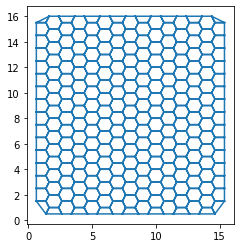

In [65]:
fig, ax = sheet_view(cellmap_original, ['y', 'x'], mode='quick')

In [66]:
[cellmap_H, geom_H, model_H, history_H] = change_specs(cellmap_original, geom_original, model_original, history_original, face_elasticity = 0.05, prefered_area = 0.6, 
                                                       FRC_lower_length_elasticity = 10, FRC_higher_length_elasticity = 5000, ECM_lower_length_elasticity = 1, 
                                                       ECM_higher_length_elasticity = 100, line_nought = 0.2 , endTime = 10)

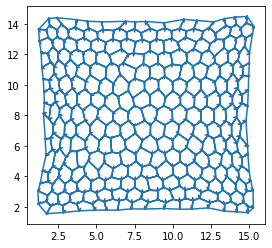

In [67]:
fig, ax = plot_forces(cellmap_H, geom_H, model_H, ['x', 'y'], 1)

In [68]:
print(cellmap_H.edge_df['length_elasticity'])
print(cellmap_H.face_df["area"].mean())
print(cellmap_H.face_df["prefered_area"].mean())
print(cellmap_H.edge_df["prefered_length"].mean())

edge
0       0.1183
1       0.2800
2       0.4274
3       0.1878
4       0.1024
         ...  
1371    0.2435
1372    0.3688
1373    0.0627
1374    0.1109
1375    0.4430
Name: length_elasticity, Length: 1376, dtype: float64
0.7042353735321588
0.5999999999999999
0.19999999999999996


In [71]:
cellmap_H.edge_df

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,uz,is_valid,rx,ry,rz,phi,sub_area,length_elasticity,prefered_length,sub_vol
edge,,,,,,,,,,,,,,,,,,,,,
0,15,0.178799,0.589498,0,17,0.291385,0.512447,1.726830,1.541512,2.018215,...,0.0,True,0.069179,-0.491957,0.0,-1.030377,0.089400,0.1183,0.2,-0.357599
1,11,0.118178,0.448051,0,15,-0.324128,0.309340,2.018215,2.053960,1.694087,...,0.0,True,0.360564,0.020490,0.0,0.321751,0.059089,0.2800,0.2,-0.236356
2,1,0.158920,0.536691,0,11,-0.502614,-0.188192,1.694087,2.363299,1.191473,...,0.0,True,0.036436,0.329830,0.0,1.892547,0.079460,0.4274,0.2,-0.317840
3,17,0.219541,0.829487,0,1,0.535357,-0.633595,1.191473,2.175107,1.726830,...,0.0,True,-0.466178,0.141637,0.0,2.944197,0.109771,0.1878,0.2,-0.439083
4,68,0.346016,1.111242,1,17,1.108186,0.082355,1.726830,1.541512,2.835016,...,0.0,True,-0.642385,-0.359975,0.0,-2.356194,0.173008,0.1024,0.2,-0.692031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,287,0.255394,0.779419,238,231,-0.778230,-0.043036,14.885362,14.482815,14.107132,...,0.0,True,0.394000,0.349960,0.0,0.785398,0.127697,0.2435,0.2,-0.510788
1372,288,0.168339,0.474035,238,287,0.042565,-0.472120,14.107132,14.439779,14.149697,...,0.0,True,-0.384230,0.306925,0.0,2.356194,0.084169,0.3688,0.2,-0.336677
1373,126,0.076992,0.562725,239,127,0.508919,-0.240126,14.828229,14.055918,15.337148,...,0.0,True,-0.188684,-0.062257,0.0,-2.356194,0.038496,0.0627,0.2,-0.153983


In [75]:
cellmap_H.edge_df(cellmap_H.edge_df["srce" == 17])

KeyError: False